# Ingestion example for elementary flows test
##### January 14, 2024

_This notebook is the baseline for the OpenLCA workbench project. With this you can do analysis of your OpenLCA result files._
* _Edit cells of the notebook as required, as you run them sequentially._


### Imports

In [1]:
import pandas as pd
from ingestion import Ingestion

## How-to configure ingestion
You need to provide an array of DataFrame creation definitions.  They will be processed in order, thus subsequent definitions may refer to DataFrames created in precedent ones.  The result of the ingestion will be a dictionary of DataFrames, each one referred to by its dataframe_name.
#### Single DataFrame creation definition
Here are the fields in a DataFrame creation definition:
* **dataframe_name** (string):
    * the identifier of the created DataFrame, i.e. `dataframes[dataframe_name]`
* **creation_method** (string):
    * two methods are possible: `"read_from_json_files"` and `"merge"`
    * these are distinctly different and the subsequent fields depend on the creation method


##### Read from JSON files (creation method)
* **input_dir** (string):
    * the directory which contains the JSON files to be processed - currently only a single directory is supported
* **file_selection_regex** (string):
    * see this __[Python regex tutorial](https://www.dataquest.io/blog/regular-expressions-data-scientists/)__ if you need explanation on working with regex
    * in the example below, the regex matches total impact files for all housing types and all farm numbers
    * regex is powerful, good to know it
* **columns** (list):
    * this is a list of column definitions for the DataFrame that is being created
    * each column definition contains:
        * **column_name** (string):
            * this will become a DataFrame column name, so follow the appropriate syntax
        * **source** (string):
            * two sources are possible: `"from_filename"` and `"from_json"`:
        * (from_filename) **spec** (string):
            * this spec is a regex, like the file_selection_regex
            * the difference is you must specify a group capture using `(` and `)`
            * a reasonable tutorial on this is __[python-regex-capturing-groups](https://pynative.com/python-regex-capturing-groups/)__
            * this column will have one value per file
            * if other columns have multiple values per file, this value will be replicated as appropriate
        * (from_json) **spec** (string):
            * this is the most complex part of the definition
            * the format of the from_json spec is based loosely on __[jmespath](https://jmespath.org/tutorial.html)__
            * but be careful, it is a simplified version of it, so the documentation is only a rough guide
            * the spec is a series of tokens separated by `.` that specifies a "JSON path"
            * the position in the series corresponds to the depth in the JSON hierarchy
            * the last token in the spec must correpond to a value or list of values
            * briefly, the possible token values (or pairs) are:
                * `<key>` - take only the sub-JSON or the value corresponding to this key
                * `[].<key>` - take the full list of sub-JSON elements or values contained in the list at this level of the JSON
                * `[n].<key>` - take the nth list element (sub-JSON or value)
                * `__keys__[].<key>` - take the full list of sub-JSON elements or values contained at this level of the JSON
                * `__keys__[n].<key>` - take the nth element (sub-JSON or value) at this level of the JSON
            * in order to really understand this, please see __[Tutorial on using the from_json spec](test_ingest.ipynb#section_id1)__

##### Merge (creation method)
* **left_dataframe** (string):
    * the name of the "left" DataFrame to merge
    * this is considered the primary DataFrame
    * it must exist in the dictionary of DataFrames already created
* **right_dataframe** (string):
    * the name of the "right" DataFrame to merge
    * this is considered the secondary DataFrame
    * it must exist in the dictionary of DataFrames already created
* **left_merge_columns** (list):
    * list of columns in the left DataFrame to merge on
* **right_merge_columns** (list):
    * list of columns in the right DataFrame to merge on

In order to really understand this, please see __[Tutorial on merging DataFrames](test_ingest.ipynb#section_id2)__

## Setup for DataFrame definition list
In this step, we set up the file regex and "specs" that are shared by the DataFrame definitions.  This makes the definitions more readable and more easily modified.


In [2]:
# Input directory:
input_dir = "C:\\Users\\Grass_Valley\\Documents\\Projects\\FSPL (UBC)\\GitLab\\openlca\\resources\\Elementary flows data sets\\"

# Filename example: 
#   Conventional egg production__Farm__A__003-with-elementary-flow-output.xlsx-result-total-impacts
conv_egg_prod = "Conventional egg production__"
regex_all_farms = "Farm__.*__.*-with-elementary-flow-output\.xlsx"
spec_housing = "Farm__(.*)__.*-with-elementary-flow-output\.xlsx"
spec_number = "Farm__.*__(.*)-with-elementary-flow-output\.xlsx"

# Regex and spec examples
# total_impacts_full_regex =   "^Conventional egg production__Farm__.*__.*-with-elementary-flow-output\.xlsx-result-total-impacts$"
# total_impacts_housing_spec = "^Conventional egg production__Farm__(.*)__.*-with-elementary-flow-output\.xlsx-result-total-impacts$"
# total_impacts_number_spec =  "^Conventional egg production__Farm__.*__(.*)-with-elementary-flow-output\.xlsx-result-total-impacts$"


## List of DataFrame definitions
* Total impacts DataFrame definition
* Upstream impacts DataFrame definition
* Combined upstream impacts DataFrame definition
* Flow impacts DataFrame definition
* Production processes DataFrame definition
* Combined flow impacts DataFrame definition

### Total impacts DataFrame definition

In [3]:
total_impacts_df_definition = {
    "dataframe_name": "total_impacts_df",
    "creation_method": "read_from_json_files",
    "input_dir": input_dir,
    "file_selection_regex": f"^{conv_egg_prod}{regex_all_farms}-result-total-impacts$",
    "columns": [
        {
            "column_name": "housingType",
            "source": "from_filename",
            "spec": f"^{conv_egg_prod}{spec_housing}-result-total-impacts$"
        },
        {
            "column_name": "farmNumber",
            "source": "from_filename",
            "spec": f"^{conv_egg_prod}{spec_number}-result-total-impacts$"
        },
        {
            "column_name": "impactCategory",
            "source": "from_json",
            "spec": "[].impactCategory.name"
        },
        {
            "column_name": "amount",
            "source": "from_json",
            "spec": "[].amount"
        },
        {
            "column_name": "refUnit",
            "source": "from_json",
            "spec": "[].impactCategory.refUnit"
        }
    ]
}

### Upstream impacts DataFrame definition

In [4]:
upstream_impacts_df_definition = {
    "dataframe_name": "upstream_impacts_df",
    "creation_method": "read_from_json_files",
    "input_dir": input_dir,
    "file_selection_regex": f"^{conv_egg_prod}{regex_all_farms}-result-upstream-of-impact-category$",
    "columns": [
        {
            "column_name": "housingType",
            "source": "from_filename",
            "spec": f"^{conv_egg_prod}{spec_housing}-result-upstream-of-impact-category$"
        },
        {
            "column_name": "farmNumber",
            "source": "from_filename",
            "spec": f"^{conv_egg_prod}{spec_number}-result-upstream-of-impact-category$"
        },
        {
            "column_name": "impactCategory",
            "source": "from_json",
            "spec": "[].__keys__[0]"
        },
        {
            "column_name": "upstreamFlow",
            "source": "from_json",
            "spec": "[].__keys__[0].[0].upstreamTechFlows.[].techFlow.flow.name"
        },
        {
            "column_name": "upstreamFlowAmount",
            "source": "from_json",
            "spec": "[].__keys__[0].[0].upstreamTechFlows.[].result"
        }
    ]
}

### Combined upstream impacts DataFrame definition

In [5]:
combined_upstream_impacts_df_definition = {
    "dataframe_name": "combined_upstream_impacts_df",
    "creation_method": "merge",
    "merge_how": "outer",
    "left_dataframe": "total_impacts_df",
    "right_dataframe": "upstream_impacts_df",
    "left_merge_columns": [
        "housingType",
        "farmNumber",
        "impactCategory"
    ],
    "right_merge_columns": [
        "housingType",
        "farmNumber",
        "impactCategory"
    ]
}

### Flow impacts DataFrame definition

In [6]:
flow_impacts_df_definition = {
    "dataframe_name": "flow_impacts_df",
    "creation_method": "read_from_json_files",
    "input_dir": input_dir,
    "file_selection_regex": f"^{conv_egg_prod}{regex_all_farms}-result-flows-of-impact-category$",
    "columns": [
        {
            "column_name": "housingType",
            "source": "from_filename",
            "spec": f"^{conv_egg_prod}{spec_housing}-result-flows-of-impact-category$"
        },
        {
            "column_name": "farmNumber",
            "source": "from_filename",
            "spec": f"^{conv_egg_prod}{spec_number}-result-flows-of-impact-category$"
        },
        {
            "column_name": "impactCategory",
            "source": "from_json",
            "spec": "[].__keys__[0]"
        },
        {
            "column_name": "enviFlowName",
            "source": "from_json",
            "spec": "[].__keys__[0].[].enviFlow.flow.name"
        },
        {
            "column_name": "enviFlowId",
            "source": "from_json",
            "spec": "[].__keys__[0].[].enviFlow.flow.@id"
        },
        {
            "column_name": "enviFlowRefUnit",
            "source": "from_json",
            "spec": "[].__keys__[0].[].enviFlow.flow.refUnit"
        },
        {
            "column_name": "enviFlowAmount",
            "source": "from_json",
            "spec": "[].__keys__[0].[].amount"
        }
    ]
}

### Production processes DataFrame definition

In [7]:
production_processes_df_definition = {
    "dataframe_name": "production_processes_df",
    "creation_method": "read_from_json_files",
    "input_dir": input_dir,
    "file_selection_regex": f"^{regex_all_farms}-production$",
    "columns": [
        {
            "column_name": "housingType",
            "source": "from_filename",
            "spec": f"^{spec_housing}-production$"
        },
        {
            "column_name": "farmNumber",
            "source": "from_filename",
            "spec": f"^{spec_number}-production$"
        },
        {
            "column_name": "UUID",
            "source": "from_json",
            "spec": "[].UUID dataset"
        },
        {
            "column_name": "flowName",
            "source": "from_json",
            "spec": "[].flow name (optional)"
        },
        {
            "column_name": "flowType",
            "source": "from_json",
            "spec": "[].type"
        },
    ]
}

### Combined flow impacts DataFrame definition

In [8]:
combined_flow_impacts_df_definition = {
    "dataframe_name": "combined_flow_impacts_df",
    "creation_method": "merge",
    "merge_how": "inner",
    "left_dataframe": "production_processes_df",
    "right_dataframe": "flow_impacts_df",
    "left_merge_columns": [
        "housingType",
        "farmNumber",
        "UUID"
    ],
    "right_merge_columns": [
        "housingType",
        "farmNumber",
        "enviFlowId"
    ]
}

## Append all DataFrame definitions into a list

In [9]:
dataframe_definition_list = []

dataframe_definition_list.append(total_impacts_df_definition)
dataframe_definition_list.append(upstream_impacts_df_definition)
dataframe_definition_list.append(combined_upstream_impacts_df_definition)
dataframe_definition_list.append(flow_impacts_df_definition)
dataframe_definition_list.append(production_processes_df_definition)
dataframe_definition_list.append(combined_flow_impacts_df_definition)

print(f"Creating {len(dataframe_definition_list)} DataFrames:")
for dataframe_definition in dataframe_definition_list:
    print(f'  {dataframe_definition["dataframe_name"]}')

Creating 6 DataFrames:
  total_impacts_df
  upstream_impacts_df
  combined_upstream_impacts_df
  flow_impacts_df
  production_processes_df
  combined_flow_impacts_df


## Use the DataFrame definition list to ingest the JSON files and create the DataFrames
* After running the cell below, the important result DataFrames are:
  * dataframes["combined_upstream_impacts_df"]
  * dataframes["combined_flow_impacts_df"]
These are Pandas DataFrames and you can analyze and visualize this as you wish.  Example visualizations are given in subsequent cells.


In [10]:
dataframes = Ingestion.create_dataframes(dataframe_definition_list)



Dataframe total_impacts_df will be created from JSON files
Processing Conventional egg production__Farm__A__003-with-elementary-flow-output.xlsx-result-total-impacts


Dataframe upstream_impacts_df will be created from JSON files
Processing Conventional egg production__Farm__A__003-with-elementary-flow-output.xlsx-result-upstream-of-impact-category


Dataframe combined_upstream_impacts_df will be merged from total_impacts_df and upstream_impacts_df, merge_how: outer


Dataframe flow_impacts_df will be created from JSON files
Processing Conventional egg production__Farm__A__003-with-elementary-flow-output.xlsx-result-flows-of-impact-category


Dataframe production_processes_df will be created from JSON files
Processing Farm__A__003-with-elementary-flow-output.xlsx-production


Dataframe combined_flow_impacts_df will be merged from production_processes_df and flow_impacts_df, merge_how: inner


### Sanity check on the length of the DataFrame
* you should be able to predict this from your specification in dataframe_creation_list

In [ ]:
print(len(dataframes["combined_upstream_impacts_df"]))
print(len(dataframes["combined_flow_impacts_df"]))
# dataframes["combined_flow_impacts_df"][0:120]

In [12]:
# Extract the DataFrames of interest.
#
combined_upstream_impacts_df = dataframes["combined_upstream_impacts_df"].copy()
combined_flow_impacts_df = dataframes["combined_flow_impacts_df"].copy()

In [13]:
# Add an error column, equal to 0.1 * upstreamFlowAmount, for testing
#
combined_upstream_impacts_df["error"] = 0.1 * combined_upstream_impacts_df["upstreamFlowAmount"]
combined_flow_impacts_df["error"] = 0.1 * combined_flow_impacts_df["enviFlowAmount"]
# combined_flow_impacts_df

## Some DataFrame manipulation for analysis
DataFrame manipulation is a bit tricky until you get used to it.  Here we will plot a stacked bar chart where:
* the housing type is A
* the impact category is Human toxicity - CML 2 baseline 2000
* the impacts are stacked by upstream flow
* there is one bar per farm
* There is a single error bar at the top of each bar representing total uncertainty

Let's look at this step by step.

#### Filter on housing type
*Note that in this example we are already filtered on housing type A because that was the only housing type represented in the input files.*

Run the cell below.

In [14]:
housing_type = "A"
selected_upstream_impacts_df = combined_upstream_impacts_df.loc[combined_upstream_impacts_df["housingType"] == housing_type]
selected_flow_impacts_df = combined_flow_impacts_df.loc[combined_flow_impacts_df["housingType"] == housing_type]

#### Filter on impact category
Run the cell below.

In [15]:
impact_category = "Global warming (GWP100) - CML 2 baseline 2000"
selected_upstream_impacts_df = selected_upstream_impacts_df.loc[selected_upstream_impacts_df["impactCategory"] == impact_category]
selected_flow_impacts_df = selected_flow_impacts_df.loc[selected_flow_impacts_df["impactCategory"] == impact_category]
selected_flow_impacts_df

,housingType,farmNumber,UUID,flowName,flowType,impactCategory,enviFlowName,enviFlowId,enviFlowRefUnit,enviFlowAmount,error
9,A,003,20185046-64bb-4c09-a8e7-e8a9e144ca98,Dinitrogen monoxide,ELEMENTARY_FLOW,Global warming (GWP100) - CML 2 baseline 2000,Dinitrogen monoxide,20185046-64bb-4c09-a8e7-e8a9e144ca98,kg,135.529122,13.552912
19,A,003,20408dd1-8534-11e0-9d78-0800200c9a66,Methane,ELEMENTARY_FLOW,Global warming (GWP100) - CML 2 baseline 2000,Methane,20408dd1-8534-11e0-9d78-0800200c9a66,kg,20.970693,2.097069


#### Get a list of upstream flows
We will use this list to break the full DataFrame into multiple DataFrames, one per upstream flow.

Run the cell below.

In [16]:
upstream_flow_list = selected_upstream_impacts_df["upstreamFlow"].unique()
upstream_flow_list

array(['Feed - layer', 'Pullets-conventional', 'Poultry Manure',
       'electricity, medium voltage',
       'transport, freight, lorry 16-32 metric ton, EURO6',
       'heat, central or small-scale, natural gas', 'tap water',
       'Diesel equipment (BTU) 2010 System',
       'petrol, unleaded, burned in machinery', 'liquefied petroleum gas',
       'light fuel oil', 'transport, tractor and trailer, agricultural'],
      dtype=object)

In [17]:
elementary_flow_list = selected_flow_impacts_df["flowName"].unique()
elementary_flow_list

array(['Dinitrogen monoxide', 'Methane'], dtype=object)

#### Get information for labelling
We are getting the ref_unit and bar tags.  In this case the bar tag is the farm number.  It is used for positioning and labelling the x-axis of the bar.

*Note that we take a copy of the DataFrame and work with the copy.  In general, Pandas does not like to read and write a DataFrame at the same time for data consistency.  So, it is good practice to take a copy.  You'll get a warning whenever Pandas thinks there is a problem.*

Run the cell below.

In [18]:
ref_unit = selected_upstream_impacts_df["refUnit"].iloc[0]
tagged_upstream_impacts_df = selected_upstream_impacts_df.copy()
tagged_upstream_impacts_df["bar_tag"] = selected_upstream_impacts_df["farmNumber"]
print(f"ref_unit: {ref_unit}")
tagged_upstream_impacts_df

ref_unit: kg CO2 eq


,housingType,farmNumber,impactCategory,amount,refUnit,upstreamFlow,upstreamFlowAmount,error,bar_tag
108,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,Feed - layer,1.440268e+00,1.440268e-01,003
109,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,Pullets-conventional,2.871787e-01,2.871787e-02,003
110,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,Poultry Manure,2.296386e-01,2.296386e-02,003
111,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,"electricity, medium voltage",3.402168e-02,3.402168e-03,003
112,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,"transport, freight, lorry 16-32 metric ton, EURO6",1.792197e-02,1.792197e-03,003
113,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,"heat, central or small-scale, natural gas",1.680299e-03,1.680299e-04,003
114,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,tap water,5.989913e-04,5.989913e-05,003
115,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,Diesel equipment (BTU) 2010 System,4.971678e-04,4.971678e-05,003
116,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,"petrol, unleaded, burned in machinery",3.727280e-04,3.727280e-05,003
117,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,liquefied petroleum gas,2.403711e-05,2.403711e-06,003


In [19]:
tagged_flow_impacts_df = selected_flow_impacts_df.copy()
tagged_flow_impacts_df["bar_tag"] = selected_flow_impacts_df["farmNumber"]
tagged_flow_impacts_df

,housingType,farmNumber,UUID,flowName,flowType,impactCategory,enviFlowName,enviFlowId,enviFlowRefUnit,enviFlowAmount,error,bar_tag
9,A,003,20185046-64bb-4c09-a8e7-e8a9e144ca98,Dinitrogen monoxide,ELEMENTARY_FLOW,Global warming (GWP100) - CML 2 baseline 2000,Dinitrogen monoxide,20185046-64bb-4c09-a8e7-e8a9e144ca98,kg,135.529122,13.552912,003
19,A,003,20408dd1-8534-11e0-9d78-0800200c9a66,Methane,ELEMENTARY_FLOW,Global warming (GWP100) - CML 2 baseline 2000,Methane,20408dd1-8534-11e0-9d78-0800200c9a66,kg,20.970693,2.097069,003


#### Split the full DataFrames by upstream flow
Run the cells below.

In [20]:
upstream_flow_dataframes = {}
for upstream_flow in upstream_flow_list:
    upstream_flow_dataframes[upstream_flow] = tagged_upstream_impacts_df.loc[tagged_upstream_impacts_df["upstreamFlow"] == upstream_flow].reset_index()

print(f"There are now {len(upstream_flow_dataframes)} upstream flow DataFrames:")
for key in upstream_flow_dataframes:
    print(f"  - {key}")

example_upstream_flow = 'tap water'
print(" ")
print(f"For example, the {example_upstream_flow} DataFrame:")
upstream_flow_dataframes[example_upstream_flow]

There are now 12 upstream flow DataFrames:
  - Feed - layer
  - Pullets-conventional
  - Poultry Manure
  - electricity, medium voltage
  - transport, freight, lorry 16-32 metric ton, EURO6
  - heat, central or small-scale, natural gas
  - tap water
  - Diesel equipment (BTU) 2010 System
  - petrol, unleaded, burned in machinery
  - liquefied petroleum gas
  - light fuel oil
  - transport, tractor and trailer, agricultural
 
For example, the tap water DataFrame:


,index,housingType,farmNumber,impactCategory,amount,refUnit,upstreamFlow,upstreamFlowAmount,error,bar_tag
0,114,A,003,Global warming (GWP100) - CML 2 baseline 2000,157.468666,kg CO2 eq,tap water,0.000599,0.00006,003


#### Do the same split for elementary flows
Run the cells below.

In [21]:
elementary_flow_dataframes = {}
for elementary_flow in elementary_flow_list:
    elementary_flow_dataframes[elementary_flow] = tagged_flow_impacts_df.loc[tagged_flow_impacts_df["enviFlowName"] == elementary_flow].reset_index()

print(f"There are now {len(elementary_flow_dataframes)} environmental flow DataFrames:")
for key in elementary_flow_dataframes:
    print(f"  - {key}")

example_elementary_flow = 'Methane'
print(" ")
print(f"For example, the {example_elementary_flow} DataFrame:")
elementary_flow_dataframes[example_elementary_flow]

There are now 2 environmental flow DataFrames:
  - Dinitrogen monoxide
  - Methane
 
For example, the Methane DataFrame:


,index,housingType,farmNumber,UUID,flowName,flowType,impactCategory,enviFlowName,enviFlowId,enviFlowRefUnit,enviFlowAmount,error,bar_tag
0,19,A,003,20408dd1-8534-11e0-9d78-0800200c9a66,Methane,ELEMENTARY_FLOW,Global warming (GWP100) - CML 2 baseline 2000,Methane,20408dd1-8534-11e0-9d78-0800200c9a66,kg,20.970693,2.097069,003


### Now the actual plotting
**The following link is GOLD for examples of how to do plotting:**

>__[matplotlib gallery](https://matplotlib.org/stable/gallery/index.html)__

#### The stacked bar plot without a legend.
Loop through the upstream flows, for each:
* set the bottom of the bar segment to the top of the previous (0 for the first)
* set the top of the bar segment to the bottom plus the upstream flow amount
* add that bar segment to the plot, each bar segment added will have its own color (the legend will be dealt with later)
* keep a running total of the error
* for the last bar segment, plot the cumulative error bar

Note that this is being done for all farms simultaneously.

And, finally, do the labelling.

Feed - layer
Pullets-conventional
Poultry Manure
electricity, medium voltage
transport, freight, lorry 16-32 metric ton, EURO6
heat, central or small-scale, natural gas
tap water
Diesel equipment (BTU) 2010 System
petrol, unleaded, burned in machinery
liquefied petroleum gas
light fuel oil
transport, tractor and trailer, agricultural
Dinitrogen monoxide
Methane


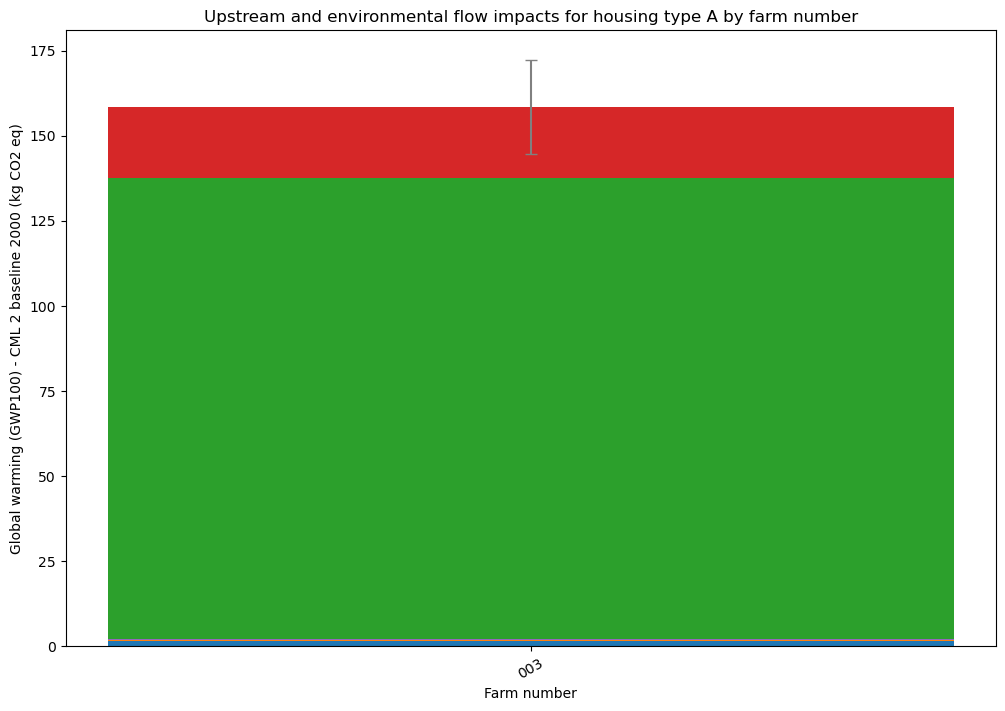

In [22]:
# This is for the plot without the legend

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

cumval=None
fig, ax = plt.subplots(figsize=(12,8))

# Upstream flows
for upstream_flow in upstream_flow_list:
    print(upstream_flow)
    upstream_flow_df = upstream_flow_dataframes[upstream_flow]
    
    if cumval is None:
        cumval = pd.DataFrame()
        cumval["bottom"] = upstream_flow_df["upstreamFlowAmount"] * 0
        cumval["error"] = upstream_flow_df["error"]

    # plot bar without error
    plt.bar(
        x=upstream_flow_df["bar_tag"], 
        height=upstream_flow_df["upstreamFlowAmount"], 
        bottom=cumval["bottom"],
    )

    cumval["bottom"] = cumval["bottom"].add(upstream_flow_df["upstreamFlowAmount"])
    cumval["error"] = cumval["error"].add(upstream_flow_df["error"])

# Environmental flows
flow_count = len(elementary_flow_list)
flow_index = 0
for elementary_flow in elementary_flow_list:
    print(elementary_flow)
    elementary_flow_df = elementary_flow_dataframes[elementary_flow]
    
    if cumval is None:
        cumval = pd.DataFrame()
        cumval["bottom"] = elementary_flow_df["enviFlowAmount"] * 0
        cumval["error"] = elementary_flow_df["error"]
    if flow_index < flow_count - 1:
        # for all flows but the last, plot bar without error
        plt.bar(
            x=elementary_flow_df["bar_tag"], 
            height=elementary_flow_df["enviFlowAmount"], 
            bottom=cumval["bottom"],
        )
    else:
        # for last flow, plot bar with error
        plt.bar(
            x=elementary_flow_df["bar_tag"], 
            height=elementary_flow_df["enviFlowAmount"], 
            bottom=cumval["bottom"], 
            yerr=cumval["error"], align='center', ecolor='gray', capsize=4
        )

    cumval["bottom"] = cumval["bottom"].add(elementary_flow_df["enviFlowAmount"])
    cumval["error"] = cumval["error"].add(elementary_flow_df["error"])
    flow_index += 1

_ = plt.xticks(rotation=30)
ax.set_xlabel("Farm number")
ax.set_ylabel(f"{impact_category} ({ref_unit})")
ax.set_title(f"Upstream and environmental flow impacts for housing type {housing_type} by farm number")

plt.show()

#### The legend.
This is done in a manner similar to the real plot.  It is just that the bar segments all have 0 height.  Also, the legend is exported as a JPEG to file.


The legend without the bounding box is in the file: legend.png


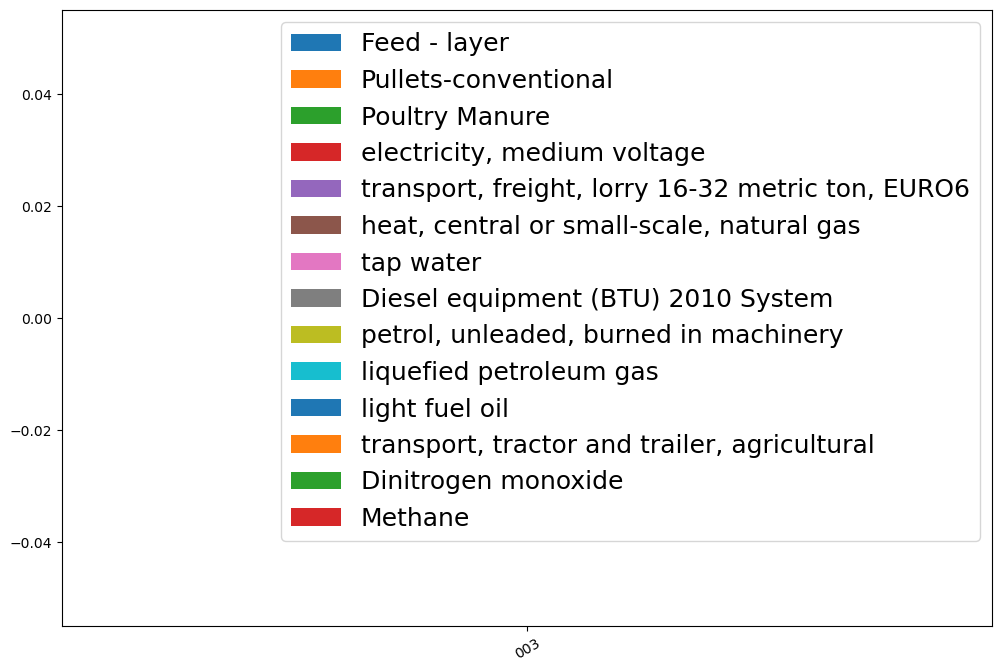

In [23]:
# This is for a separate legend

import pandas as pd
import matplotlib.pyplot as plt

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

cumval=None
fig = plt.figure(figsize=(12,8))
for upstream_flow in upstream_flow_list:
    upstream_flow_df = upstream_flow_dataframes[upstream_flow]
    if cumval is None:
        cumval = pd.DataFrame()
        cumval["bottom"] = upstream_flow_df["upstreamFlowAmount"] * 0
    plt.bar(x=upstream_flow_df["bar_tag"], height=cumval["bottom"], bottom=cumval["bottom"], label=upstream_flow)

for elementary_flow in elementary_flow_list:
    elementary_flow_df = elementary_flow_dataframes[elementary_flow]
    plt.bar(x=elementary_flow_df["bar_tag"], 
        height=cumval["bottom"], 
        bottom=cumval["bottom"],
        label=elementary_flow
    )

_ = plt.xticks(rotation=30)
legend = plt.legend(fontsize=18)

legend_filename="legend.png"
export_legend(legend, filename=legend_filename)
print(f"\nThe legend without the bounding box is in the file: {legend_filename}")
plt.show()